## Student's Names: Siro Brotón Gutierrez  y Yan Chen Zhou
---

# Lab 1: Solving the Heat Equation – A Demonstration of Stiffness

## The Method of Lines (MOL)

Linear systems of ODEs naturally arise when solving PDEs. For example, consider solving the following initial boundary value problem:

$$u_t = u_{xx},\quad x\in(0,1),\quad u(0) = u(1) = 0,\quad u(x,0) = f(x).$$

To solve this:

1. We first discretize the spatial variable $x$ on a uniform grid:  
   $$x_i = ih,\quad i=0,\dots,N, \quad\text{with } h = 1/N.$$  
   Define $U_i(t) \approx u(x_i,t)$.  

2. Approximate the second derivative using the second-order finite difference formula:
   
   $$ \left.\frac{\partial^2u}{\partial x^2}\right|_{(x_j,t)}\approx\frac{u(x_j-h,t)-2u(x_j,t)+u(x_j+h,t)}{h^2}. $$
   
   Substituting into the Heat equation, we obtain the ODE system:
   
   $$U_i'(t) = \frac{1}{h^2}\left(U_{i-1}(t)-2U_i(t)+U_{i+1}(t)\right), \quad i=1,\dots,m.$$ 
   
   Or, in matrix-vector form:
   
   $$ \mathbf{U'}(t) = A \mathbf{U}, $$
   
   where $\mathbf{U}(t) = [U_1(t),\dots,U_m(t)]^T$ and $A$ is the $m \times m$ matrix:
   
   $$ A =\frac{1}{h^2}
   \begin{bmatrix}
   -2 & 1 &  &  &  \\
   1 & -2 & 1 &  &  \\
    & \ddots & \ddots & \ddots &  \\
    &  & 1 & -2 & 1 \\
    &  &  & 1 & -2
   \end{bmatrix}. $$
   
   This ODE system is called the **semidiscrete method**.

3. We then solve this system using a numerical ODE solver, a technique called the **method of lines (MOL)**.

### 1. Numerical Implementation

Write a script to solve this PDE problem with the following requirements:

- Include an `input` section where all parameters of the PDE problem are defined.
- Implement a function that returns matrix $A$ given $h$ and $m$. In Python, this can be done using NumPy:

```python
import numpy as np

def Amatrix(m, h):
    A = (-2 / h**2) * np.diag(np.ones(m)) \
        + (1 / h**2) * np.diag(np.ones(m - 1), 1) \
        + (1 / h**2) * np.diag(np.ones(m - 1), -1)
    return A
```

- Define the right-hand side function of the semidiscrete method. 
- Modify your ODE solvers (FE, RK4, BE and Crank-Nicolson) to allow to solve the linear system of ODEs $$ \mathbf{U'}(t) = A \mathbf{U}. $$

---


In [130]:
# Imports 
import numpy as np
import scipy.optimize as opti
import matplotlib.pyplot as plt


# Parameters
a, b, m = 0, 1, 41
h = 1 / (m + 1)
x = np.linspace(a, b, m+2)
dt = 0.5 * h**2  # CFL condition
tspan = np.arange(0, 0.5 + dt, dt)

# Function definitions
def u_exact(x, t):
    return np.sin(np.pi * x) * np.exp(-np.pi**2 * t)

def Amatrix(m, h):
    A = (-2 / h**2) * np.eye(m) + (1 / h**2) * (np.eye(m, k=1) + np.eye(m, k=-1))
    return A

# def Amatrix(m, h):
#     A = (-2 / h**2) * np.diag(np.ones(m)) \
#         + (1 / h**2) * np.diag(np.ones(m - 1), 1) \
#         + (1 / h**2) * np.diag(np.ones(m - 1), -1)
#     return A

# Initialize ODE
A = Amatrix(m, h)
f = lambda u: A @ u


## Systems of differential equations

For systems of differential equations, $u' = Au$ the general solution is of the form $u(t) = e^{At} u(0).$ The behavior of this solution depends largely on the eigenvalues of $A$. A necessary condition for absolute stability is that $z = \Delta t\\lambda$ be in the stability region for each eigenvalue $\lambda$ of $A$. To see this, suppose that $A \in \mathbb{R}^{m\times m}$ can be diagonalized as $A = R\Lambda R^{-1}$ . Then,
$$u' = Au = R\Lambda R^{-1} u.$$
Let $v = R^{-1} u$ so then we obtain $m$ decoupled equations:
$$v' = \Lambda v.$$
Let $\lambda_k$, $k = 1, \dots , m,$ be the eigenvalues of $A$. If we use one method to solve the system of equations, then we must choose the time step $\Delta t$ so that $\Delta t\lambda_k$ lies in the stability region for all $k = 1, \dots , m$.



### 2. Eigenvalues of Matrix $A$

By simply substitution of the eigenfunction $u^{(k)}_j=\sin(k\pi jh)$ into the discretized operator $(u^{(k)}_{j-1}-2u^{(k)}_{j}+u^{(k)}_{j+1})/h^2=\lambda_k u^{(k)}_j$, it is possible to show that 

$$ \lambda_k = -\frac{2}{h^2} \left[ 1-\cos\left(k\pi h\right)\right],\quad k = 1,\dots, m. $$

are the eigenvalues of $A$. Verify this numerically. 

**Hint:** you can do that in Python using:

```python
eigenvalues = np.linalg.eigvals(A)  # Numerical eigenvalues
dk = -2 / h**2 * (1 - np.cos(np.arange(1, m + 1) * np.pi * h))
```

---


In [131]:
A = Amatrix(m, h)
eigenvalues = np.linalg.eigvals(A)                              # Numerical eigenvalues
dk = -2 / h**2 * (1 - np.cos(np.arange(1, m + 1) * np.pi * h))  # Analytical eigenvalues

print(eigenvalues)
print(np.flip(dk))
print(dt)
print(np.max(np.abs(eigenvalues)) * dt)

[-7046.13499646 -7016.59515492 -6967.54567418 -6899.26085881
 -6812.12258522 -6706.61816596 -6583.33762455 -6442.97039579
 -6286.30147015 -6114.20700382 -5927.64941886 -5727.67202096
 -5515.39316485 -5292.         -5058.74183161 -4816.92313396
 -4567.89625532 -4313.053855   -4053.82111507 -3791.64777017
 -3528.         -3264.35222983 -3002.17888493 -2742.946145
 -2488.10374468 -2239.07686604 -1997.25816839    -9.86500354
   -39.40484508   -88.45432582  -156.73914119  -243.87741478
  -349.38183404  -472.66237545  -613.02960421  -769.69852985
  -941.79299618 -1128.35058114 -1328.32797904 -1540.60683515
 -1764.        ]
[-7046.13499646 -7016.59515492 -6967.54567418 -6899.26085881
 -6812.12258522 -6706.61816596 -6583.33762455 -6442.97039579
 -6286.30147015 -6114.20700382 -5927.64941886 -5727.67202096
 -5515.39316485 -5292.         -5058.74183161 -4816.92313396
 -4567.89625532 -4313.053855   -4053.82111507 -3791.64777017
 -3528.         -3264.35222983 -3002.17888493 -2742.946145
 -2488.1037


### 3. Forward Euler Method
Consider the forward Euler method applied to the heat equation:

$$ U_j^{n+1}=U_j^{n} + \frac{\Delta t}{h^2} \left(U_{j-1}^n - 2U_j^n + U_{j+1}^n \right). $$

The local truncation error for this method can be shown to be

$$ \tau(x_j,t_n)=\frac{u(x_j,t_{n+1})-u(x_j,t_{n})}{\Delta t} - \frac{1}{h^2} \left[u(x_{j-1},t_n) - 2u(x_j,t_n) + u(x_{j+1},t_n) \right] = \mathcal{O}(\Delta t+h^2).$$

#### (a) Stability Analysis
Find the condition on $\Delta t \lambda_k$ for absolute stability. This yields the so-called *CFL condition*.

#### (b) Numerical Experiment
Suppose that the exact solution is $u(x,t) = \sin(\pi x)e^{-\pi^2t}$, and we want to integrate the equation up to $T=0.5$. Run your code for different spatial resolutions $m=10,20,40,80,160,\dots$. For each $m$, make sure that $\Delta t$ meets the condition for absolute stability in (b). Compute the global error at $t=T$ and determine the order of convergence (similar to what we did in class with an ODE). Measure execution time.

#### (c) Solution Plot
Plot the evolution of the solution in a $(x,t)$-coordinate system. What do you observe if the stability condition in (b) (*CFL condition*) is not met?


```python
import numpy as np
import matplotlib.pyplot as plt

# Parameters
a, b, m = 0, 1, 41
h = 1 / (m + 1)
x = np.linspace(a, b, m+2)
dt = 0.5 * h**2  # CFL condition
tspan = np.arange(0, 0.5 + dt, dt)

# Function definitions
def u_exact(x, t):
    return np.sin(np.pi * x) * np.exp(-np.pi**2 * t)

def Amatrix(m, h):
    A = (-2 / h**2) * np.eye(m) + (1 / h**2) * (np.eye(m, k=1) + np.eye(m, k=-1))
    return A

def forward_euler(f, tspan, u0, dt):
    u = [u0]
    for _ in tspan[:-1]:
        u.append(u[-1] + dt * f(u[-1]))
    return np.array(u)

# Initialize and solve ODE
A = Amatrix(m, h)
f = lambda u: A @ u
u0 = u_exact(x[1:-1], 0)

u = forward_euler(f, tspan, u0, dt)
u = np.vstack([np.zeros(len(tspan)), u.T, np.zeros(len(tspan))])  # Apply BCs

# Plot results
X, T = np.meshgrid(x, tspan)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, u.T, cmap='viridis')

ax.set_title('u(x,t)')
ax.set_xlabel('x')
ax.set_ylabel('t')
plt.show()

```

---


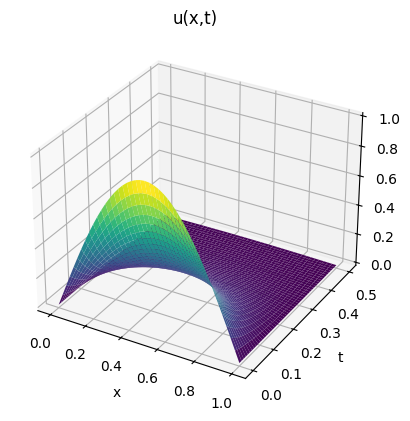

In [132]:
def forward_euler(f, tspan, u0, dt):
    u = [u0]
    for _ in tspan[:-1]:
        u.append(u[-1] + dt * f(u[-1]))
    return np.array(u)

# Initialize and solve ODE
A = Amatrix(m, h)
f = lambda u: A @ u
u0 = u_exact(x[1:-1], 0)

u = forward_euler(f, tspan, u0, dt)
u = np.vstack([np.zeros(len(tspan)), u.T, np.zeros(len(tspan))])  # Apply BCs

# Plot results
X, T = np.meshgrid(x, tspan)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, u.T, cmap='viridis')

ax.set_title('u(x,t)')
ax.set_xlabel('x')
ax.set_ylabel('t')
plt.show()


### 4. RK4 Method
Repeat part (3a) using the Runge-Kutta 4th order (RK4) method.



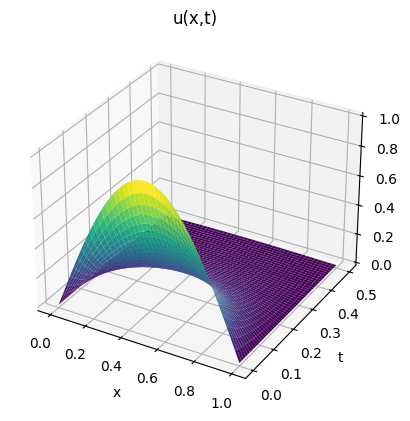

In [133]:
import numpy as np
import matplotlib.pyplot as plt


def rk4(f, tspan, u0, dt):
    u = [u0]
    for _ in tspan[:-1]:
        y1 = u[-1] 
        y2 = u[-1] + (dt/2)*f(y1)
        y3 = u[-1] + (dt/2)*f(y2)
        y4 = u[-1] + dt*f(y3)
        f1, f2, f3, f4 = f(y1), f(y2), f(y3), f(y4)
        ui = u[-1] + (dt/6)*(f1+2*f2+2*f3+f4)
        u.append(ui)

    return np.array(u)

# Initialize and solve ODE
A = Amatrix(m, h)
f = lambda u: A @ u
u0 = u_exact(x[1:-1], 0)

u = rk4(f, tspan, u0, dt)
u = np.vstack([np.zeros(len(tspan)), u.T, np.zeros(len(tspan))])  # Apply BCs

# Plot results
X, T = np.meshgrid(x, tspan)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, u.T, cmap='viridis')

ax.set_title('u(x,t)')
ax.set_xlabel('x')
ax.set_ylabel('t')
plt.show()

### 5. Implicit Method
Repeat part (3a) using the BE and Trapezoidal methods for this problem.



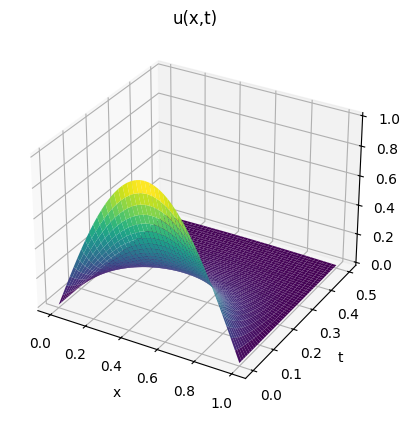

In [134]:
def backward_euler(f, tspan, u0, dt):
    u = [u0]
    for _ in tspan[:-1]:
        be = lambda x: x-u[-1]-dt*f(x)
        u.append(opti.fsolve(be, u[-1]))
    return np.array(u)

# Initialize and solve ODE
A = Amatrix(m, h)
f = lambda u: A @ u
u0 = u_exact(x[1:-1], 0)

u = backward_euler(f, tspan, u0, dt)
u = np.vstack([np.zeros(len(tspan)), u.T, np.zeros(len(tspan))])  # Apply BCs

# Plot results
X, T = np.meshgrid(x, tspan)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, u.T, cmap='viridis')

ax.set_title('u(x,t)')
ax.set_xlabel('x')
ax.set_ylabel('t')
plt.show()

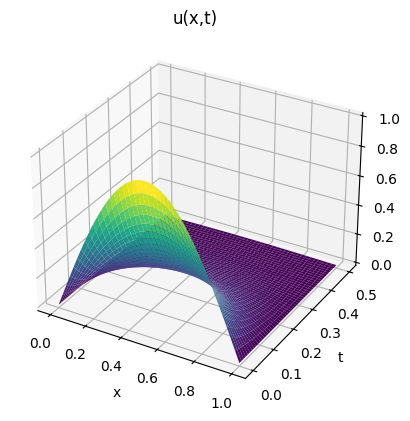

In [135]:
def trapezoidal(f, tspan, u0, dt):
    u = [u0]
    for _ in tspan[:-1]:
        trpz = lambda x: x-u[-1]-0.5*dt*(f(u[-1])+f(x))
        u.append(opti.fsolve(trpz, u[-1]))
    return np.array(u)


u = trapezoidal(f, tspan, u0, dt)
u = np.vstack([np.zeros(len(tspan)), u.T, np.zeros(len(tspan))])  # Apply BCs

# Plot results
X, T = np.meshgrid(x, tspan)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, T, u.T, cmap='viridis')

ax.set_title('u(x,t)')
ax.set_xlabel('x')
ax.set_ylabel('t')
plt.show()


### 6. Efficiency Comparison
Compare the efficiency of all methods and discuss the best choice for solving this PDE.


In [137]:
import math

# Parameters
a, b, m = 0, 1, 41
h = 1 / (m + 1)
dt = 0.5 * h**2  # CFL condition

# Initialize and solve ODE
A = Amatrix(m, h)
f = lambda u: A @ u
x = np.linspace(a, b, m+2)
u0 = u_exact(x[1:-1], 0)
tspan = np.arange(0, 0.5 + dt, dt)

sol = []
for t in tspan:
    sol.append(u_exact(x[1:-1], t)) 
sol = np.array(sol)
sol = np.vstack([np.zeros(len(tspan)), sol.T, np.zeros(len(tspan))])  

u = forward_euler(f, tspan, u0, dt)
u_fe = np.vstack([np.zeros(len(tspan)), u.T, np.zeros(len(tspan))])  # Apply BCs
u = backward_euler(f, tspan, u0, dt)
u_be = np.vstack([np.zeros(len(tspan)), u.T, np.zeros(len(tspan))])  # Apply BCs
u = rk4(f, tspan, u0, dt)
u_rk4 = np.vstack([np.zeros(len(tspan)), u.T, np.zeros(len(tspan))])  # Apply BCs
u = trapezoidal(f, tspan, u0, dt)
u_trpz = np.vstack([np.zeros(len(tspan)), u.T, np.zeros(len(tspan))])  # Apply BCs

err_fe = abs(u_fe - sol)
err_be = abs(u_be - sol)
err_rk4 = abs(u_rk4 - sol)
err_trpz = abs(u_trpz - sol)



The plot below takes the point $x$ which is closest to $0.5$

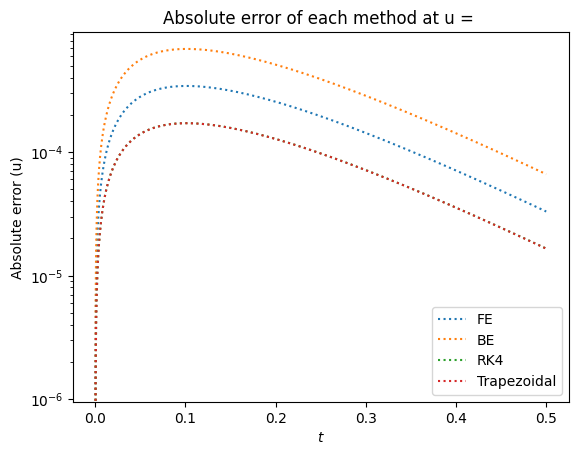

0.04036690501731346 0.08060831251969888 0.020170564401588233 0.020142375122236437


In [128]:

plt.semilogy(tspan, err_fe[math.ceil(m/2), :], ':', label='FE')
plt.semilogy(tspan, err_be[math.ceil(m/2), :], ':', label='BE')
plt.semilogy(tspan, err_rk4[math.ceil(m/2), :], ':', label='RK4')
plt.semilogy(tspan, err_trpz[math.ceil(m/2), :], ':', label='Trapezoidal')

plt.legend()
plt.title("Absolute error of each method at u = ")
plt.xlabel("$t$")
plt.ylabel("Absolute error (u)")
plt.show()

err_fe = np.linalg.norm(u_fe - sol, ord=2)
err_be = np.linalg.norm(u_be - sol, ord=2)
err_rk4 = np.linalg.norm(u_rk4 - sol, ord=2)
err_trpz = np.linalg.norm(u_trpz - sol, ord=2)
print(err_fe, err_be, err_rk4, err_trpz)

Forward Euler is obviously inside the stabliity region since it is inside $-2 < -k\max|\lambda| < 0$

In [114]:
print(-np.max(np.abs(eigenvalues)) * dt)

-1.9972037971811791
